# Loading synthetic data models

### Table of contents

1. [**One-dimensional regression**](#1D)
2. [**Two-dimensional regression**](#2D)



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../scripts/fit")
import synthetic
import template



import matplotlib.pyplot as plt
#plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

# seed everything
seed = 1234
prng_state = jax.random.PRNGKey(seed)
rng = np.random.default_rng(seed)

<a id='svgp'></a>
## Data

In [3]:
### data ###
data_path = "../data/synthetic/"
session_name = "syn_data_seed123"
max_ISI_order = 4

select_fracs = [0.0, 1.0]

dataset_dict = synthetic.spikes_dataset(session_name, data_path, max_ISI_order, select_fracs)

#covariates = dataset_dict['covariates']
#x_t, y_t = covariates['x'], covariates['y']


In [4]:
dataset_dict["ISIs"].shape

(973113, 9, 4)

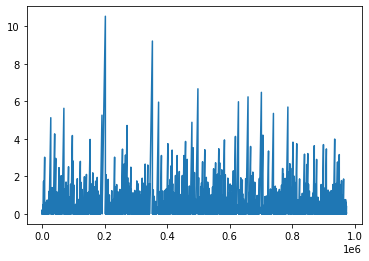

In [5]:
ISIs = dataset_dict["ISIs"]

plt.plot(ISIs[:, 0, 0])
plt.show()

In [6]:
dataset_dict['spiketrains'].sum(-1)

array([3367., 2387., 2096., 2121., 6833., 6721., 6835., 2161., 1556.])

<a id='behav'></a>
## Nonparametric point process

In [7]:
### model ###
datadir = '../scripts/checkpoint/'

ISI_order = 4
name = 'syn_data_seed123ISI4sel0.0to1.0_isi4__nonparam_pp_gp-48-matern32-1000-2._X[x-y]_Z[]'.format(ISI_order)



results = pickle.load(
    open(datadir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covariates, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covariates.shape[-1]
spikes = observations.astype(bool)


# model
model = template.build_model(
    config, dataset_dict, synthetic.observed_kernel_dict_induc_list, rng, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(datadir + name + ".eqx", model)


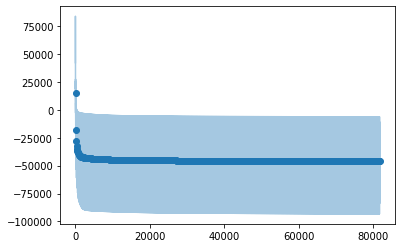

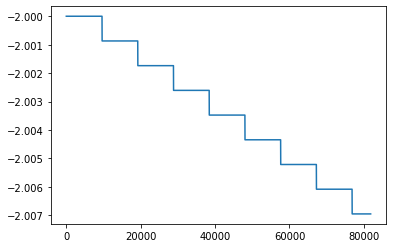

In [8]:
batches = len(results['losses']['train_loss_batches'])
epochs = len(results['losses']['train_loss_epochs'])
delta_be = batches // epochs

plt.plot(np.arange(batches), results['losses']['train_loss_batches'], alpha=0.4)
plt.scatter(delta_be//2 + delta_be*np.arange(epochs), results['losses']['train_loss_epochs'])
plt.show()

plt.plot(np.log10(results['lrs']))
plt.show()

In [12]:
jnp.exp(model.obs_model.log_warp_tau)

Array([0.8467633 , 1.76839   , 1.2289313 , 1.4755108 , 1.0157384 ,
       0.9616031 , 0.95695496, 1.2512867 , 1.1838311 ], dtype=float32)

In [16]:
uisi = np.unique(ISIs[0, :, 1])
uisi = uisi[~np.isnan(uisi)]

In [17]:
prng_state = jr.PRNGKey(123)
jitter = 1e-6

st = 0
xs = covariates
deltas = ISIs[:, st:, :ISI_order] if ISIs is not None else ISIs
ys = spikes[:, st:]
ys_filt = spikes[:, st+filter_length:]

post_mean_rho = model.obs_model.posterior_mean(xs, deltas, jitter, None)

rescaled_intervals = lib.utils.spikes.time_rescale(
    ys.T, post_mean_rho.T, model.obs_model.pp.dt, max_intervals=100)

pp = lib.likelihoods.Exponential(
    model.obs_model.pp.obs_dims, model.obs_model.pp.dt)
sort_cdfs, T_KS, p = lib.utils.stats.KS_test(pp.cum_density, rescaled_intervals)


# LPD
lik_int_method = {
    "type": "GH", 
    "approx_pts": 50, 
}

lpd, _ = model.obs_model.variational_expectation(
    prng_state, jitter, xs[None, None], deltas[None], ys[None], False, lik_int_method, False)


[autoreload of gaussneuro.observations.bnpp failed: Traceback (most recent call last):
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to fiel

AttributeError: module 'gaussneuro.utils' has no attribute 'neural'

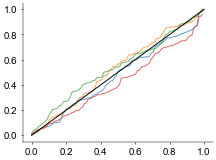

0.00767826


In [165]:
for n in range(len(sort_cdfs)):
    plt.plot(np.linspace(0., 1., len(sort_cdfs[n])), sort_cdfs[n], alpha=0.7)
plt.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')
plt.show()

print(lpd)

In [187]:
evalsteps = 120
num_samps = 100
N = observations.shape[0]
x_dims = model.inp_model.x_dims

cisi_t_eval = jnp.linspace(0.0, 1., evalsteps)
isi_cond = jnp.ones((N, ISI_order-1))
x_cond = 250.*jnp.ones(x_dims)


prng_state = jr.PRNGKey(123)


ISI_density = model.obs_model.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=False,
)


mean_ISI = model.obs_model.sample_conditional_ISI_expectation(
    prng_state,
    num_samps,
    lambda x: x,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    f_num_quad_pts=100,
    isi_num_quad_pts=100, 
    prior=False,
)


secmom_ISI = model.obs_model.sample_conditional_ISI_expectation(
    prng_state,
    num_samps,
    lambda x: x**2,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    f_num_quad_pts=100,
    isi_num_quad_pts=100, 
    prior=False,
)

var_ISI = (secmom_ISI - mean_ISI**2)
CV_ISI = np.sqrt(var_ISI) / (mean_ISI + 1e-12)

[autoreload of lib.inference.svgp failed: Traceback (most recent call last):
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class

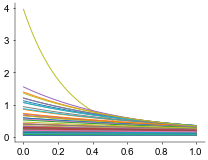

In [218]:
n = 1

plt.plot(cisi_t_eval, ISI_density[:, n, :].T)
plt.show()

In [209]:
### evaluation ###
x_evals = 10
y_evals = 10
x_dims = 2

x_eval = jnp.linspace(0, 500, x_evals)
y_eval = jnp.linspace(0, 500, y_evals)
evalsteps = x_eval*y_eval

x_eval, y_eval = np.meshgrid(x_eval, y_eval)
or_shape = x_eval.shape

pos_eval = jnp.stack([x_eval, y_eval], axis=-1).reshape(-1, x_dims)
theta_eval = 0.0 * jnp.ones((pos_eval.shape[0], 1))

locs_eval = jnp.concatenate((pos_eval, theta_eval), axis=-1)

In [210]:
def m(x_cond):
    mean_ISI = model.obs_model.sample_conditional_ISI_expectation(
        prng_state,
        num_samps,
        lambda x: x,
        isi_cond, 
        x_cond,
        int_eval_pts=1000,
        f_num_quad_pts=100,
        isi_num_quad_pts=100, 
        prior=False,
    )
    return mean_ISI

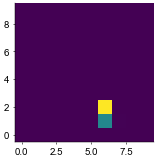

In [89]:
n = 4

mISI = 1. / mean_ISI.mean(1).reshape(*or_shape, -1)


plt.imshow(mISI[..., n], origin='lower', cmap='viridis')

<a id='behav'></a>
## Poisson point process

In [17]:
### model ###
checkpoint_dir = '../scripts/checkpoint/'
name = 'syn_data_seed123ISI4sel0.0to1.0_PP-log__factorized_gp-32-100_X[x-y-theta]_Z[]'


results = pickle.load(
    open(datadir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covariates, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covariates.shape[-1]
spikes = observations.astype(bool)


# model
model = template.build_model(
    config, dataset_dict, synthetic.observed_kernel_dict_induc_list, seed, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(checkpoint_dir + name + ".eqx", model)


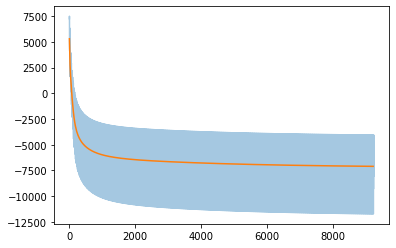

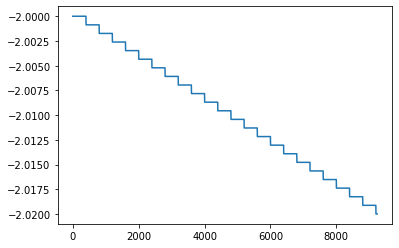

In [18]:
batches = len(results['losses']['train_loss_batches'])
epochs = len(results['losses']['train_loss_epochs'])
delta_be = batches // epochs

plt.plot(np.arange(batches), results['losses']['train_loss_batches'], alpha=0.4)
plt.plot(delta_be*np.arange(epochs), results['losses']['train_loss_epochs'])
plt.show()

plt.plot(np.log10(results['lrs']))
plt.show()

In [20]:
prng_state = jr.PRNGKey(123)
jitter = 1e-6

st = 0
xs = covariates
deltas = ISIs.transpose(1, 0, 2)[:, st:, :1] if ISIs is not None else ISIs
ys = spikes[:, st:]
ys_filt = spikes[:, st+filter_length:]

post_mean_rho = model.obs_model.evaluate_posterior_mean(
    prng_state, xs, ys_filt, jitter, None)

rescaled_intervals = lib.utils.neural.time_rescale(
    ys.T, post_mean_rho.T, model.obs_model.likelihood.dt, max_intervals=100)

pp = lib.likelihoods.Exponential(
    model.obs_model.likelihood.obs_dims, model.obs_model.likelihood.dt)
quants = lib.utils.stats.ISIs_to_quantiles(pp.cum_density, rescaled_intervals)
sort_cdfs, T_KS, p = lib.utils.stats.KS_test(quants)


# LPD
lik_int_method = {
    "type": "GH", 
    "approx_pts": 100, 
}

lpd, _ = model.obs_model.variational_expectation(
    prng_state, jitter, xs[None, None], ys, ys_filt, False, lik_int_method, False)


AttributeError: module 'gaussneuro.utils.neural' has no attribute 'KS_test'

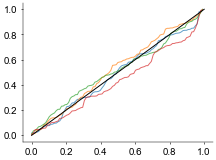

0.00767702


In [42]:
for n in range(len(sort_cdfs)):
    plt.plot(np.linspace(0., 1., len(sort_cdfs[n])), sort_cdfs[n], alpha=0.7)
plt.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')
plt.show()

print(lpd)

In [12]:
### evaluation ###
x_evals = 40
y_evals = 40
x_dims = 2

x_eval = jnp.linspace(0, 500, x_evals)
y_eval = jnp.linspace(0, 500, y_evals)
evalsteps = x_eval*y_eval

x_eval, y_eval = np.meshgrid(x_eval, y_eval)
or_shape = x_eval.shape

pos_eval = jnp.stack([x_eval, y_eval], axis=-1).reshape(-1, x_dims)
theta_eval = 0.0 * jnp.ones((pos_eval.shape[0], 1))

sp_locs = model.obs_model.gp.induc_locs
locs_eval = jnp.concatenate((pos_eval, theta_eval), axis=-1)[None, None, ...]


post_mean, post_cov, KL = model.obs_model._gp_posterior(
    locs_eval, mean_only=False, diag_cov=True, compute_KL=True, jitter=1e-8)

neurons = model.obs_model.likelihood.obs_dims

post_mean = post_mean[0].reshape(neurons, *or_shape)
post_var = post_cov[0].reshape(neurons, *or_shape)

link_fn = model.obs_model.likelihood.inverse_link

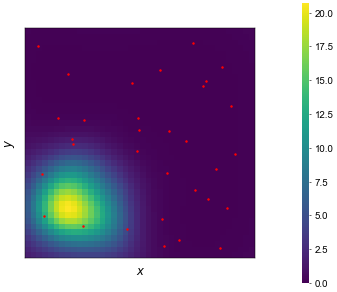

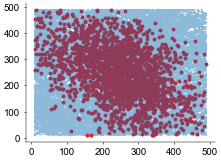

In [21]:
n = 1


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 1])
lib.utils.plots.decorate_ax(ax)  # get all four spines around plot
ax.scatter(sp_locs[n, :, 0], sp_locs[n, :, 1], marker='.', c='r')
im = ax.imshow(link_fn(post_mean[n, ...]), 
           extent=[locs_eval[..., 0].min(), locs_eval[..., 0].max(), 
                   locs_eval[..., 1].min(), locs_eval[..., 1].max()], 
           aspect='equal', origin='lower', cmap='viridis', vmin=0.)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#ax.set_title('noise correlations')


ax = fig.add_subplot(spec[0, 2])
lib.utils.plots.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)


# plt.scatter(sp_locs[n, :, 0], sp_locs[n, :, 1], marker='.', c='r')
# plt.imshow(post_var[n, ...], 
#            extent=[locs_eval[..., 0].min(), locs_eval[..., 0].max(), 
#                    locs_eval[..., 1].min(), locs_eval[..., 1].max()], 
#            aspect='equal', vmin=0., origin='lower', cmap='viridis')
# plt.show()

fig = plt.figure()
n = 0
plt.plot(x_t, y_t, alpha=0.5)
plt.scatter(x_t[spikes[n].astype(bool)], y_t[spikes[n].astype(bool)], c='r')
plt.show()